In [1]:
%matplotlib inline

DIFAX Replication
=================

This example replicates the traditional DIFAX images for upper-level
observations.

By: Kevin Goebbert

Observation data comes from Iowa State Archive, accessed through the
Siphon package. Contour data comes from the GFS 0.5 degree analysis.
Classic upper-level data of Geopotential Height and Temperature are
plotted.


In [2]:
from datetime import datetime, timedelta
import urllib.request

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import StationPlot
from metpy.units import units
import numpy as np
from siphon.simplewebservice.iastate import IAStateUpperAir
import xarray as xr


Plotting High/Low Symbols
-------------------------

A helper function to plot a text symbol (e.g., H, L) for relative
maximum/minimum for a given field (e.g., geopotential height).


In [3]:

def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color.

    Parameters
    ----------
        lon : 2D array
            Plotting longitude values
        lat : 2D array
            Plotting latitude values
        data : 2D array
            Data that you wish to plot the max/min symbol placement
        extrema : str
            Either a value of max for Maximum Values or min for Minimum Values
        nsize : int
            Size of the grid box to filter the max and min values to plot a reasonable number
        symbol : str
            Text to be placed at location of max/min value
        color : str
            Name of matplotlib colorname to plot the symbol (and numerical value, if plotted)
        plot_value : Boolean (True/False)
            Whether to plot the numeric value of max/min point

    Return
    ------
        The max/min symbol will be plotted on the current axes within the bounding frame
        (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)


Station Information
-------------------

A helper function for obtaining radiosonde station information (e.g.,
latitude/longitude) requried to plot data obtained from each station.
Original code by github user sgdecker.


In [4]:

def station_info(stid):
    r"""Provide information about weather stations.

    Parameters
    ----------
    stid: str or iterable object containing strs
         The ICAO or IATA code(s) for which station information is requested.
    with_units: bool
         Whether to include units for values that have them. Default True.

    Returns
    -------
    info: dict
         Information about the station(s) within a dictionary with these keys:
             'state': Two-character ID of the state/province where the station is located,
                       if applicable
             'name': The name of the station
             'lat': The latitude of the station [deg]
             'lon': The longitude of the station [deg]
             'elevation': The elevation of the station [m]
             'country': Two-character ID of the country where the station is located

    Modified code from Steven Decker, Rutgers University

    """
    # Provide a helper function for later usage
    def str2latlon(s):
        deg = float(s[:3])
        mn = float(s[-3:-1])
        if s[-1] == 'S' or s[-1] == 'W':
            deg = -deg
            mn = -mn
        return deg + mn / 60.

    # Various constants describing the underlying data
    url = 'https://www.aviationweather.gov/docs/metar/stations.txt'
    # file = 'stations.txt'
    state_bnds = slice(0, 2)
    name_bnds = slice(3, 19)
    icao_bnds = slice(20, 24)
    iata_bnds = slice(26, 29)
    lat_bnds = slice(39, 45)
    lon_bnds = slice(47, 54)
    z_bnds = slice(55, 59)
    cntry_bnds = slice(81, 83)

    # Generalize to any number of IDs
    if isinstance(stid, str):
        stid = [stid]

    # Get the station dataset
    infile = urllib.request.urlopen(url)
    data = infile.readlines()
#     infile = open(file, 'rb')
#     data = infile.readlines()

    state = []
    name = []
    lat = []
    lon = []
    z = []
    cntry = []

    for s in stid:
        s = s.upper()
        for line_bytes in data:
            line = line_bytes.decode('UTF-8')
            icao = line[icao_bnds]
            iata = line[iata_bnds]
            if len(s) == 3 and s in iata or len(s) == 4 and s in icao:
                state.append(line[state_bnds].strip())
                name.append(line[name_bnds].strip())
                lat.append(str2latlon(line[lat_bnds]))
                lon.append(str2latlon(line[lon_bnds]))
                z.append(float(line[z_bnds]))
                cntry.append(line[cntry_bnds])

                break
        else:
            state.append('NA')
            name.append('NA')
            lat.append(np.nan)
            lon.append(np.nan)
            z.append(np.nan)
            cntry.append('NA')

    infile.close()

    return {'state': np.array(state), 'name': np.array(name), 'lat': np.array(lat),
            'lon': np.array(lon), 'elevation': np.array(z), 'country': np.array(cntry),
            'units': {'lat': 'deg', 'lon': 'deg', 'z': 'm'}}


Observation Data
----------------

Set a date and time for upper-air observations (should only be 00 or 12
UTC for the hour).

Request all data from Iowa State using the Siphon package. The result is
a pandas DataFrame containing all of the sounding data from all
available stations.


In [5]:
# Set date for desired UPA data
today = datetime.utcnow()

# Go back one day to ensure data availability
date = datetime(today.year, today.month, today.day, 0) - timedelta(days=1)

# Request data using Siphon request for data from Iowa State Archive
data = IAStateUpperAir.request_all_data(date)


Subset Observational Data
-------------------------

From the request above will give all levels from all radisonde sites
available through the service. For plotting a pressure surface map there
is only need to have the data from that level. Below the data is subset
and a few parameters set based on the level chosen. Additionally, the
station information is obtained and latitude and longitude data is added
to the DataFrame.


In [6]:
level = 500

if (level == 925) | (level == 850) | (level == 700):
    cint = 30
    def hght_format(v): return format(v, '.0f')[1:]
elif level == 500:
    cint = 60
    def hght_format(v): return format(v, '.0f')[:3]
elif level == 300:
    cint = 120
    def hght_format(v): return format(v, '.0f')[:3]
elif level < 300:
    cint = 120
    def hght_format(v): return format(v, '.0f')[1:4]

# Create subset of all data for a given level
data_subset = data.pressure == level
df = data[data_subset]

# Get station lat/lon from look-up file; add to Dataframe
stn_info = station_info(list(df.station.values))
df.insert(10, 'latitude', stn_info['lat'])
df.insert(11, 'longitude', stn_info['lon'])


Gridded Data
------------

Obtain GFS gridded output for contour plotting. Specifically,
geopotential height and temperature data for the given level and subset
for over North America. Data are smoothed for aesthetic reasons.


In [7]:
# Get GFS data and subset to North America for Geopotential Height and Temperature
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg_ana/'
                     'GFS_Global_0p5deg_ana_{0:%Y%m%d}_{0:%H}00.grib2'.format(
                         date)).metpy.parse_cf()

# Geopotential height and smooth
hght = ds.Geopotential_height_isobaric.metpy.sel(
    vertical=level*units.hPa, time=date, lat=slice(70, 15), lon=slice(360-145, 360-50))
smooth_hght = mpcalc.smooth_n_point(hght, 9, 10)

# Temperature, smooth, and convert to Celsius
tmpk = ds.Temperature_isobaric.metpy.sel(
    vertical=level*units.hPa, time=date, lat=slice(70, 15), lon=slice(360-145, 360-50))
smooth_tmpc = (mpcalc.smooth_n_point(tmpk, 9, 10)).to('degC')


Create DIFAX Replication
------------------------

Plot the observational data and contours on a Lambert Conformal map and
add features that resemble the historic DIFAX maps.


/home/travis/miniconda/envs/training/lib/python3.7/site-packages/metpy/plots/station_plot.py:300: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/home/travis/miniconda/envs/training/lib/python3.7/site-packages/metpy/plots/station_plot.py:300: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)


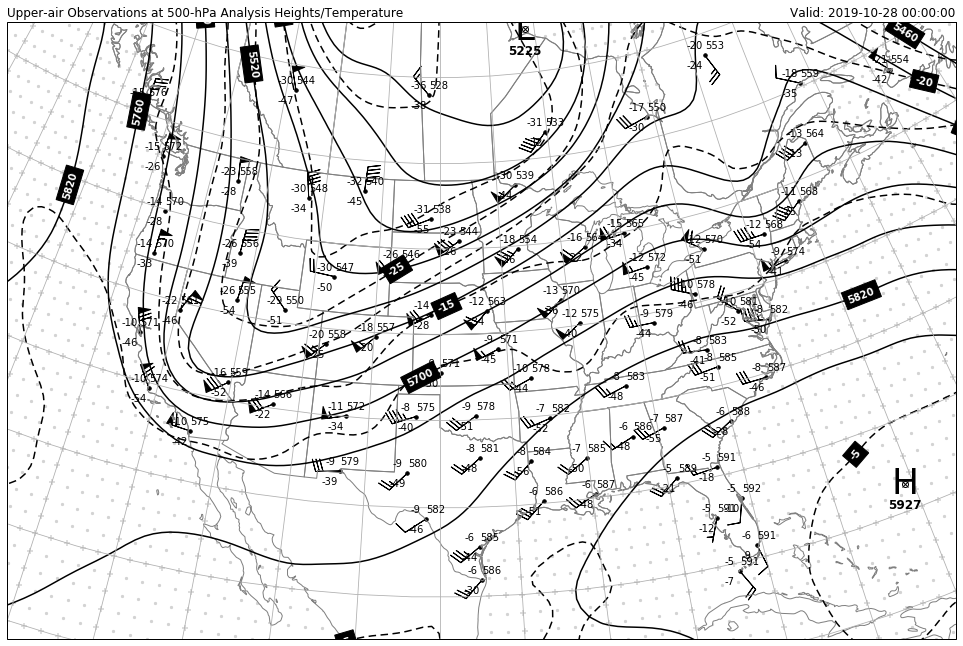

In [8]:
# Set up map coordinate reference system
mapcrs = ccrs.LambertConformal(
    central_latitude=45, central_longitude=-100, standard_parallels=(30, 60))

# Set up station locations for plotting observations
point_locs = mapcrs.transform_points(
    ccrs.PlateCarree(), df['longitude'].values, df['latitude'].values)

# Start figure and set graphics extent
fig = plt.figure(1, figsize=(17, 15))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-125, -70, 20, 55])

# Add map features for geographic reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='white')
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='grey')

# Plot plus signs every degree lat/lon
plus_lat = []
plus_lon = []
other_lat = []
other_lon = []

for x in hght.lon.values[::2]:
    for y in hght.lat.values[::2]:
        if (x % 5 == 0) | (y % 5 == 0):
            plus_lon.append(x)
            plus_lat.append(y)
        else:
            other_lon.append(x)
            other_lat.append(y)
ax.scatter(other_lon, other_lat, s=5, marker='o',
           transform=ccrs.PlateCarree(), color='lightgrey', zorder=-1)
ax.scatter(plus_lon, plus_lat, s=30, marker='+',
           transform=ccrs.PlateCarree(), color='lightgrey', zorder=-1)

# Add gridlines for every 5 degree lat/lon
ax.gridlines(linestyle='solid', ylocs=range(15, 71, 5), xlocs=range(-150, -49, 5))

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 10 pt.
stationplot = StationPlot(ax, df['longitude'].values, df['latitude'].values, clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point.
stationplot.plot_parameter('NW', df['temperature'], color='black')
stationplot.plot_parameter('SW', df['dewpoint'], color='black')

# A more complex example uses a custom formatter to control how the geopotential height
# values are plotted. This is set in an earlier if-statement to work appropriate for
# different levels.
stationplot.plot_parameter('NE', df['height'], formatter=hght_format)

# Add wind barbs
stationplot.plot_barb(df['u_wind'], df['v_wind'], length=7, pivot='tip')

# Plot Solid Contours of Geopotential Height
cs = ax.contour(hght.lon, hght.lat, smooth_hght,
                range(0, 20000, cint), colors='black', transform=ccrs.PlateCarree())
clabels = plt.clabel(cs, fmt='%d', colors='white', inline_spacing=5, use_clabeltext=True)

# Contour labels with black boxes and white text
for t in clabels:
    t.set_bbox({'facecolor': 'black', 'pad': 4})
    t.set_fontweight('heavy')

# Plot Dashed Contours of Temperature
cs2 = ax.contour(hght.lon, hght.lat, smooth_tmpc, range(-60, 51, 5),
                 colors='black', transform=ccrs.PlateCarree())
clabels = plt.clabel(cs2, fmt='%d', colors='white', inline_spacing=5, use_clabeltext=True)

# Set longer dashes than default
for c in cs2.collections:
    c.set_dashes([(0, (5.0, 3.0))])

# Contour labels with black boxes and white text
for t in clabels:
    t.set_bbox({'facecolor': 'black', 'pad': 4})
    t.set_fontweight('heavy')

# Plot filled circles for Radiosonde Obs
ax.scatter(df['longitude'].values, df['latitude'].values, s=12,
           marker='o', color='black', transform=ccrs.PlateCarree())

# Use definition to plot H/L symbols
plot_maxmin_points(hght.lon, hght.lat, smooth_hght.m, 'max', 50,
                   symbol='H', color='black', transform=ccrs.PlateCarree())
plot_maxmin_points(hght.lon, hght.lat, smooth_hght.m, 'min', 25,
                   symbol='L', color='black', transform=ccrs.PlateCarree())

# Add titles
plt.title('Upper-air Observations at {}-hPa Analysis Heights/Temperature'.format(level),
          loc='left')
plt.title('Valid: {}'.format(date), loc='right')

plt.show()